In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime,timedelta
import datetime as dt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import *

import tensorflow
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

from keras.callbacks import EarlyStopping
from keras.layers import SimpleRNN, LSTM, GRU
import tensorflow as tf
from datetime import datetime

print("Import Libraries Sucessfully!!")

2022-06-01 14:01:59.645088: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-01 14:01:59.645116: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Import Libraries Sucessfully!!


In [ ]:
# Load datasets
data = pd.read_csv('aggregated_hourly_data.csv')

In [ ]:
data.shape

(2962043, 28)

In [ ]:
data_model = data[0:100000] 

In [ ]:
data_multi = data_model[['date','temp','wetb','dewpt','vappr']]
data_multi

,date,temp,wetb,dewpt,vappr
0,2007-12-31 02:00:00,9.2,8.0,6.6,9.8
1,2007-12-31 03:00:00,9.3,7.8,5.9,9.3
2,2007-12-31 04:00:00,9.3,7.7,5.8,9.2
3,2007-12-31 05:00:00,9.6,8.3,6.8,9.9
4,2007-12-31 06:00:00,9.8,8.5,7.1,10.1
...,...,...,...,...,...
99995,2019-05-28 13:00:00,13.2,9.2,4.4,8.4
99996,2019-05-28 14:00:00,14.2,9.5,4.0,8.2
99997,2019-05-28 15:00:00,14.6,9.5,3.3,7.8
99998,2019-05-28 16:00:00,13.9,9.7,4.8,8.6


In [ ]:
## Check null value
data_multi.isnull().sum()

date     0
temp     0
wetb     0
dewpt    0
vappr    0
dtype: int64

In [ ]:
# convert time data into datetime
data_multi['date']=pd.to_datetime(data_multi['date'])

/tmp/ipykernel_17419/43300887.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_multi['date']=pd.to_datetime(data_multi['date'])


In [ ]:
print('The time series starts from: ', data_multi.date.min())
print('The time series ends on: ', data_multi.date.max())

The time series starts from:  2007-12-31 02:00:00
The time series ends on:  2019-05-28 17:00:00


In [ ]:
# Set Datetime feature as index
data_multi.set_index('date',inplace=True)
data_multi.head()

,temp,wetb,dewpt,vappr
date,,,,
2007-12-31 02:00:00,9.2,8.0,6.6,9.8
2007-12-31 03:00:00,9.3,7.8,5.9,9.3
2007-12-31 04:00:00,9.3,7.7,5.8,9.2
2007-12-31 05:00:00,9.6,8.3,6.8,9.9
2007-12-31 06:00:00,9.8,8.5,7.1,10.1


## EDA

In [ ]:
data_multi.shape

(100000, 4)

In [ ]:
data_multi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100000 entries, 2007-12-31 02:00:00 to 2019-05-28 17:00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   temp    100000 non-null  float64
 1   wetb    100000 non-null  float64
 2   dewpt   100000 non-null  float64
 3   vappr   100000 non-null  float64
dtypes: float64(4)
memory usage: 3.8 MB


In [ ]:
data_multi.describe()

,temp,wetb,dewpt,vappr
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,9.969327,8.404531,6.681146,10.235813
std,5.263679,4.585070,4.618596,3.175685
min,-10.400000,-10.600000,-12.400000,2.400000
25%,6.200000,5.100000,3.300000,7.700000
50%,10.100000,8.600000,6.900000,9.900000
75%,13.800000,11.900000,10.100000,12.400000
max,28.300000,21.600000,19.500000,22.600000


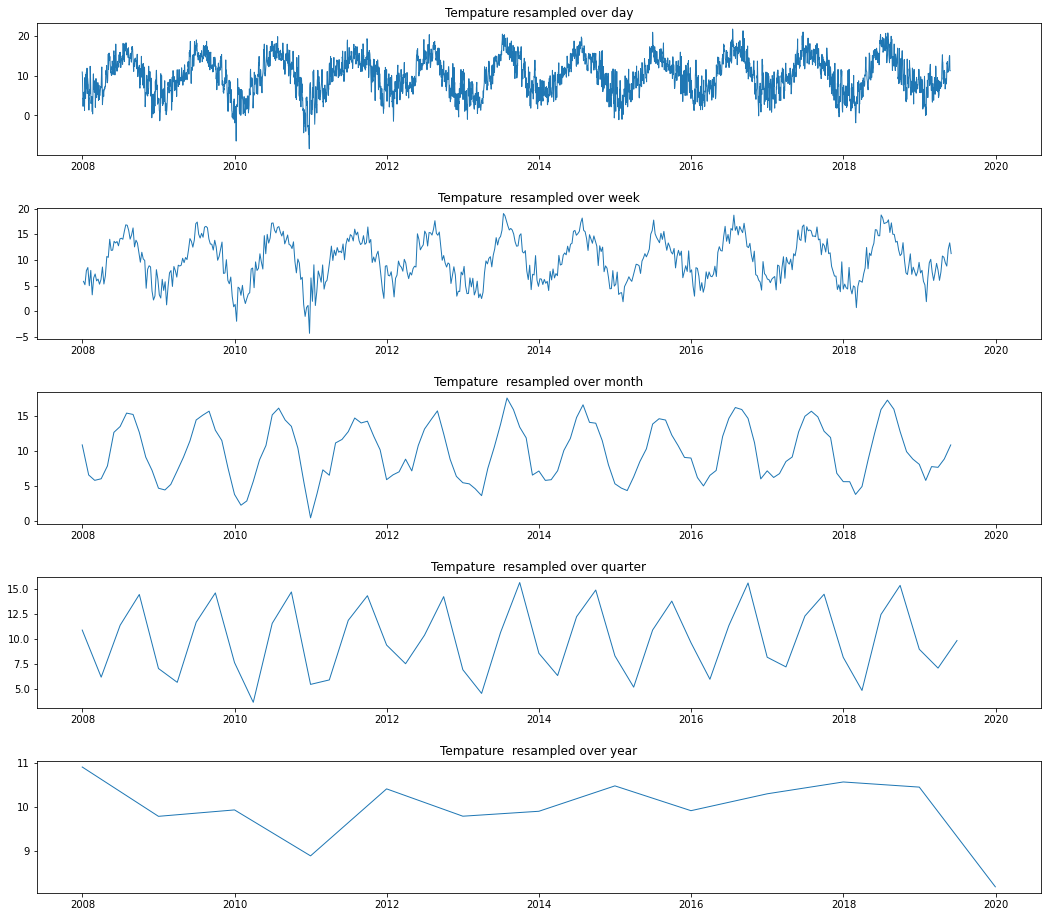

In [ ]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(data_multi['temp'].resample('D').mean(),linewidth=1)
ax1.set_title('Tempature resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(data_multi['temp'].resample('W').mean(),linewidth=1)
ax2.set_title('Tempature  resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(data_multi['temp'].resample('M').mean(),linewidth=1)
ax3.set_title('Tempature  resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(data_multi['temp'].resample('Q').mean(),linewidth=1)
ax4.set_title('Tempature  resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(data_multi['temp'].resample('A').mean(),linewidth=1)
ax5.set_title('Tempature  resampled over year')
ax5.tick_params(axis='both', which='major');

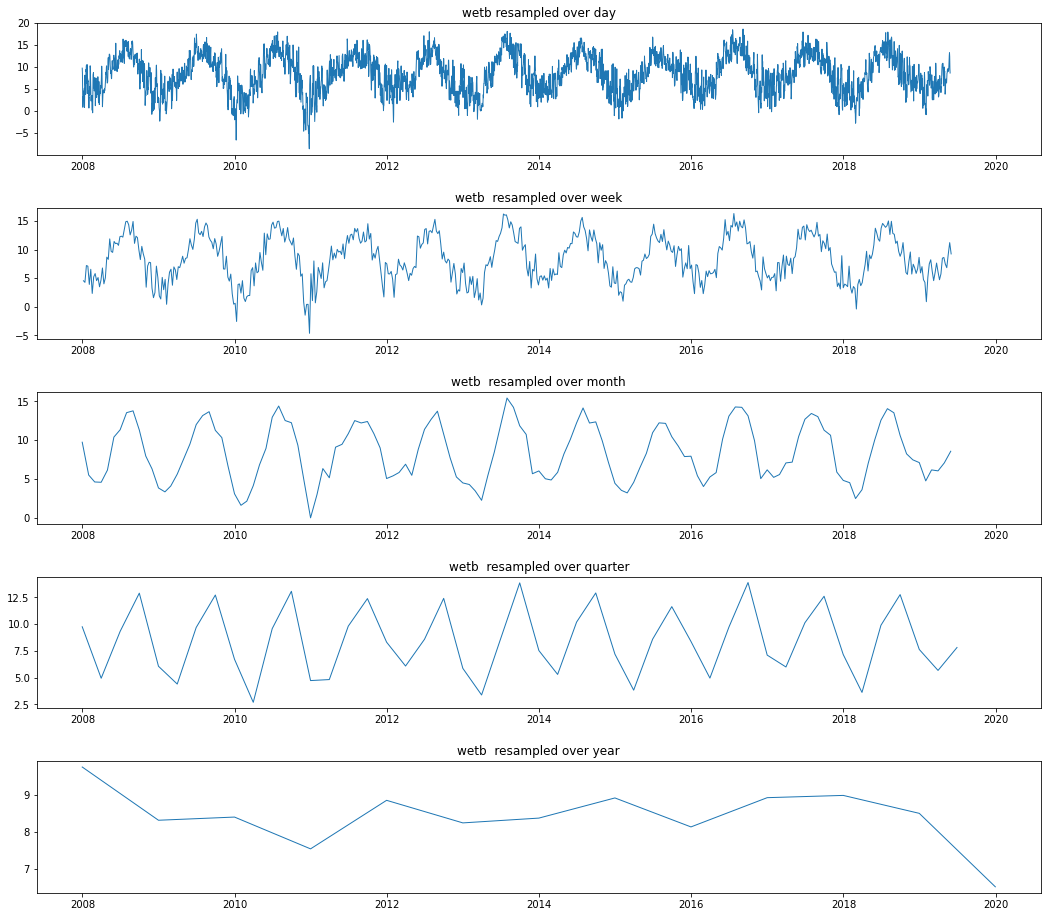

In [ ]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(data_multi['wetb'].resample('D').mean(),linewidth=1)
ax1.set_title('wetb resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(data_multi['wetb'].resample('W').mean(),linewidth=1)
ax2.set_title('wetb  resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(data_multi['wetb'].resample('M').mean(),linewidth=1)
ax3.set_title('wetb  resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(data_multi['wetb'].resample('Q').mean(),linewidth=1)
ax4.set_title('wetb  resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(data_multi['wetb'].resample('A').mean(),linewidth=1)
ax5.set_title('wetb  resampled over year')
ax5.tick_params(axis='both', which='major');

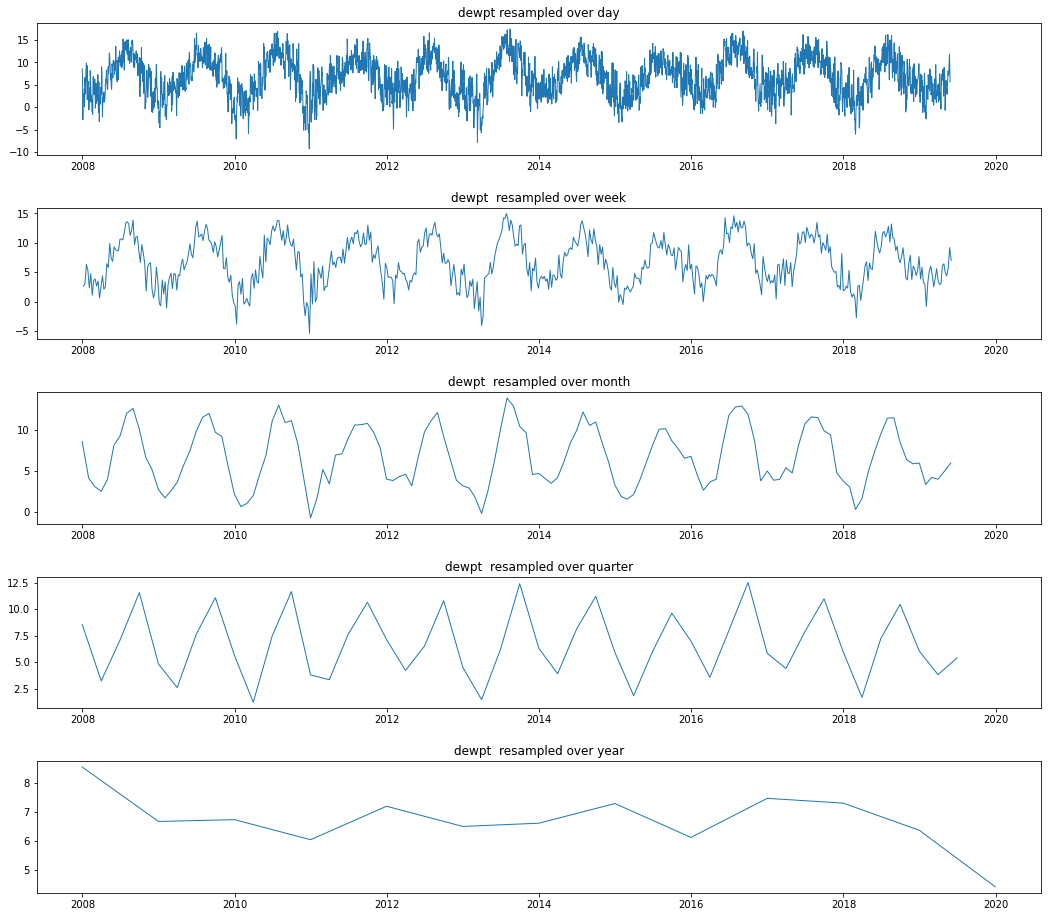

In [ ]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(data_multi['dewpt'].resample('D').mean(),linewidth=1)
ax1.set_title('dewpt resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(data_multi['dewpt'].resample('W').mean(),linewidth=1)
ax2.set_title('dewpt  resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(data_multi['dewpt'].resample('M').mean(),linewidth=1)
ax3.set_title('dewpt  resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(data_multi['dewpt'].resample('Q').mean(),linewidth=1)
ax4.set_title('dewpt  resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(data_multi['dewpt'].resample('A').mean(),linewidth=1)
ax5.set_title('dewpt  resampled over year')
ax5.tick_params(axis='both', which='major');

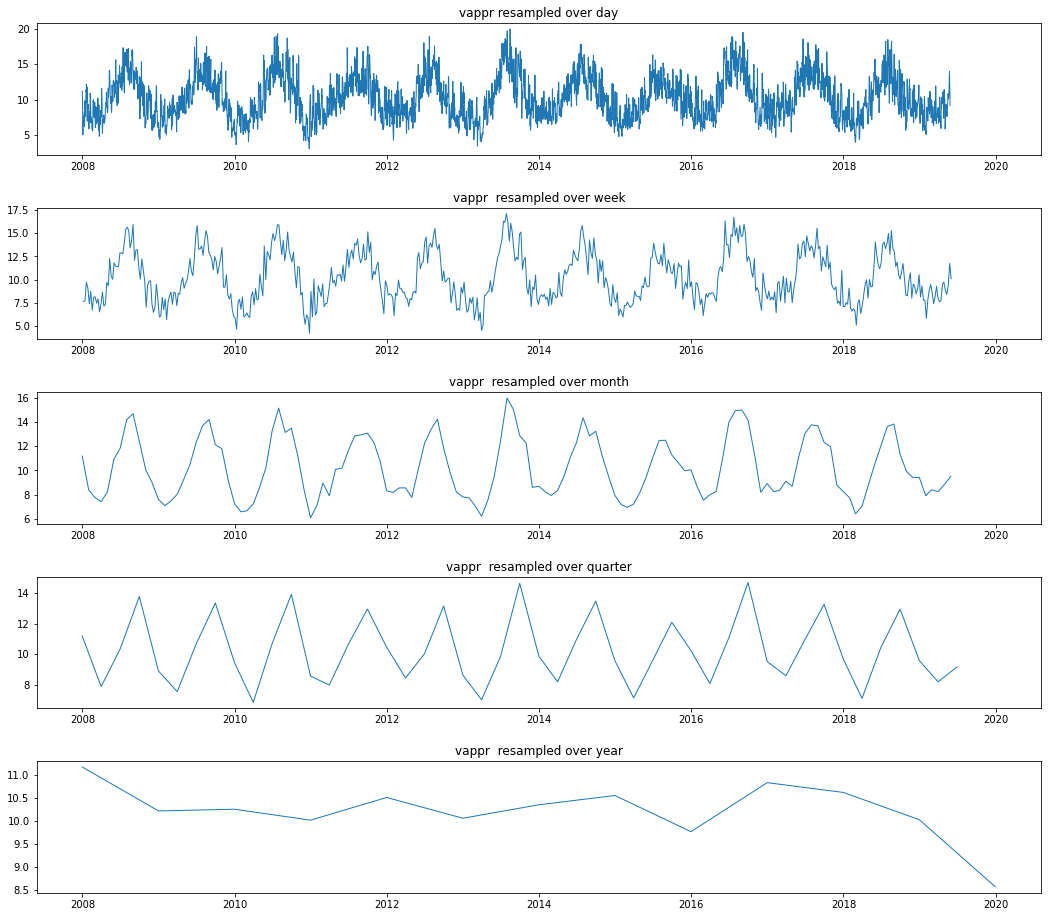

In [ ]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(data_multi['vappr'].resample('D').mean(),linewidth=1)
ax1.set_title('vappr resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(data_multi['vappr'].resample('W').mean(),linewidth=1)
ax2.set_title('vappr  resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(data_multi['vappr'].resample('M').mean(),linewidth=1)
ax3.set_title('vappr  resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(data_multi['vappr'].resample('Q').mean(),linewidth=1)
ax4.set_title('vappr  resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(data_multi['vappr'].resample('A').mean(),linewidth=1)
ax5.set_title('vappr  resampled over year')
ax5.tick_params(axis='both', which='major');

<AxesSubplot:>

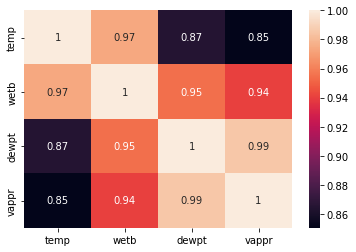

In [ ]:
sns.heatmap(data_multi.corr(),annot=True)

In [ ]:
data_multi.corr()

,temp,wetb,dewpt,vappr
temp,1.000000,0.973887,0.865053,0.850534
wetb,0.973887,1.000000,0.954751,0.940561
dewpt,0.865053,0.954751,1.000000,0.985897
vappr,0.850534,0.940561,0.985897,1.000000


In [ ]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [ ]:
adf_test(data_multi['temp'])

ADF Statistics: -10.219963252551088
p- value: 5.356909944728258e-18
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [ ]:
adf_test(data_multi['wetb'])

ADF Statistics: -10.935308359282995
p- value: 9.59326078852952e-20
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [ ]:
adf_test(data_multi['dewpt'])

ADF Statistics: -12.980496698664943
p- value: 2.9506679395239303e-24
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [ ]:
adf_test(data_multi['vappr'])

ADF Statistics: -12.85126563922215
p- value: 5.346547794754657e-24
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


### Checking Autocorrelation 

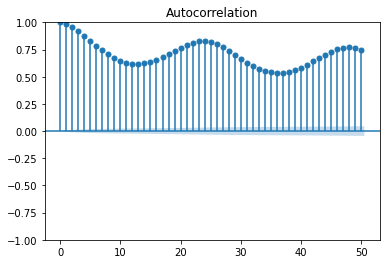

In [ ]:
acf = plot_acf(data_multi["temp"])

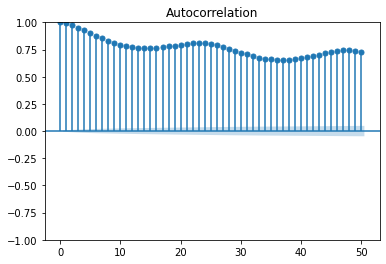

In [ ]:
acf = plot_acf(data_multi["wetb"])

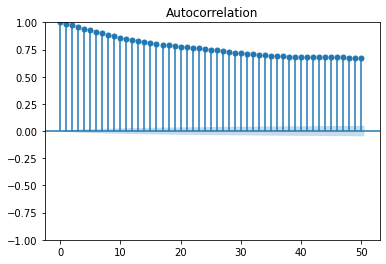

In [ ]:
acf = plot_acf(data_multi["dewpt"])

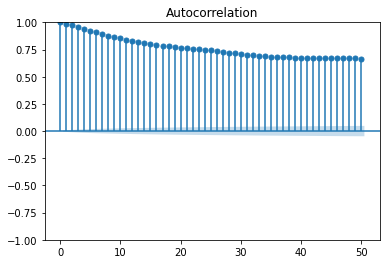

In [ ]:
acf = plot_acf(data_multi["vappr"])

/home/neosoft/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


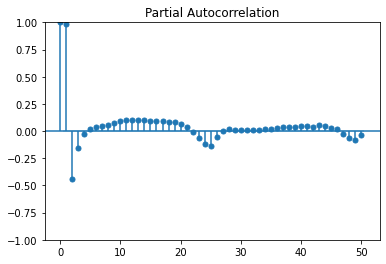

In [ ]:
pacf = plot_pacf(data_multi["temp"])

/home/neosoft/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


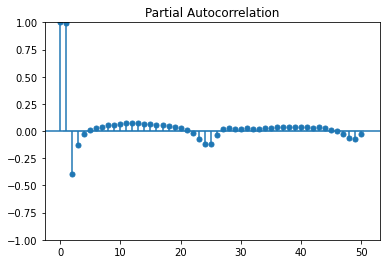

In [ ]:
pacf = plot_pacf(data_multi["wetb"])

/home/neosoft/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


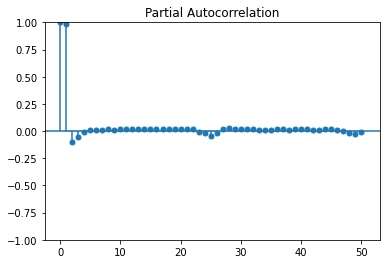

In [ ]:
pacf = plot_pacf(data_multi["dewpt"])

/home/neosoft/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


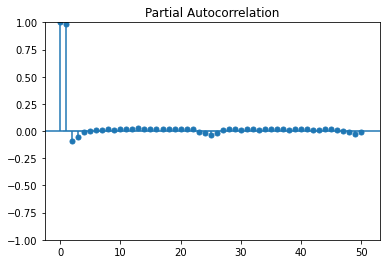

In [ ]:
pacf = plot_pacf(data_multi["vappr"])

## Checking Seasonal data

In [ ]:
result_temp = seasonal_decompose(data_multi['temp'])

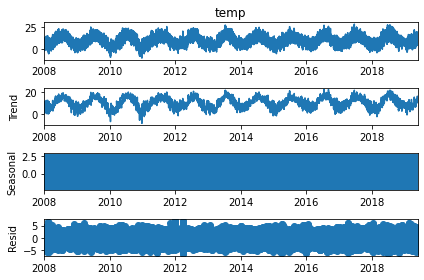

In [ ]:
result_temp.plot();

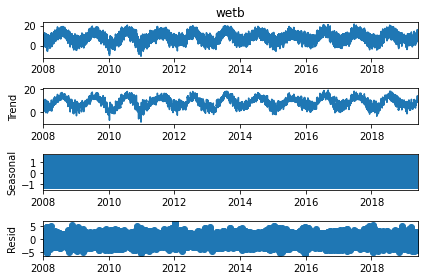

In [ ]:
result_wetb = seasonal_decompose(data_multi['wetb'])
result_wetb.plot();

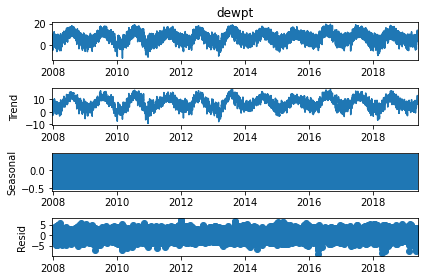

In [ ]:
result_dewpt = seasonal_decompose(data_multi['dewpt'])
result_dewpt.plot();

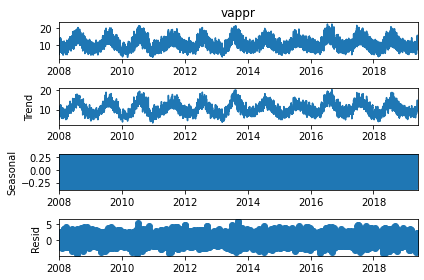

In [ ]:
result_vappr = seasonal_decompose(data_multi['vappr'])
result_vappr.plot();

## split data into train test

In [ ]:
train_dataset_end = datetime(2018,12,31)
timedelta(days=1)

datetime.timedelta(days=1)

In [ ]:
train_data = data_multi[:train_dataset_end]
test_data = data_multi[train_dataset_end+timedelta(days=1):]

In [ ]:
print(train_data.shape, test_data.shape)

(96431, 4) (3546, 4)


In [ ]:
train_data.head()

,temp,wetb,dewpt,vappr
date,,,,
2007-12-31 02:00:00,9.2,8.0,6.6,9.8
2007-12-31 03:00:00,9.3,7.8,5.9,9.3
2007-12-31 04:00:00,9.3,7.7,5.8,9.2
2007-12-31 05:00:00,9.6,8.3,6.8,9.9
2007-12-31 06:00:00,9.8,8.5,7.1,10.1


In [ ]:
test_data.head()

,temp,wetb,dewpt,vappr
date,,,,
2019-01-01 00:00:00,9.6,7.8,5.6,9.1
2019-01-01 01:00:00,8.6,7.1,5.3,8.9
2019-01-01 02:00:00,8.3,6.9,5.3,8.9
2019-01-01 03:00:00,9.1,7.6,5.8,9.2
2019-01-01 04:00:00,9.2,7.7,5.9,9.3


In [ ]:
test_data.shape

(3546, 4)

In [ ]:
def feature_scaling(data):
    scaler = MinMaxScaler().fit(data)
    data_norm = scaler.transform(data)
    #return as dataframe
    #data = pd.DataFrame(data_norm, index=data.index, columns=data.columns)
    
    return data_norm, scaler 

In [ ]:
train_data_scaled, scaler = feature_scaling(train_data)
train_data_scaled

array([[0.50645995, 0.57763975, 0.59561129, 0.36633663],
       [0.50904393, 0.57142857, 0.57366771, 0.34158416],
       [0.50904393, 0.56832298, 0.57053292, 0.33663366],
       ...,
       [0.53488372, 0.61180124, 0.63009404, 0.4009901 ],
       [0.52971576, 0.61180124, 0.64576803, 0.42079208],
       [0.51421189, 0.59937888, 0.63322884, 0.40594059]])

In [ ]:
test_data_scaled, scaler = feature_scaling(test_data)
test_data_scaled

array([[0.5234375 , 0.59      , 0.57068063, 0.42735043],
       [0.484375  , 0.555     , 0.55497382, 0.41025641],
       [0.47265625, 0.545     , 0.55497382, 0.41025641],
       ...,
       [0.71875   , 0.675     , 0.45026178, 0.31623932],
       [0.69140625, 0.685     , 0.52879581, 0.38461538],
       [0.734375  , 0.705     , 0.5078534 , 0.36752137]])

In [ ]:
trainX = []
trainY = []

n_future = 5   # Number of days we want to look into the future based on the past days.
n_past = 15 # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my scaler_train has a shape (96431, 4)
#96431 refers to the number of data points and 4 refers to the columns (multi-variables).
for i in range(n_past, len(train_data_scaled) - n_future +1):
    trainX.append(train_data_scaled[i - n_past:i, 0:train_data_scaled.shape[1]])
    trainY.append(train_data_scaled[i + n_future - 1:i + n_future,0])

X_train, y_train = np.array(trainX), np.array(trainY)

print('X_train shape == {}'.format(X_train.shape))
print('y_train shape == {}'.format(y_train.shape))

X_train shape == (96412, 15, 4)
y_train shape == (96412, 1)


In [ ]:
testX = []
testY = []

n_future = 5   # Number of days we want to look into the future based on the past days.
n_past = 15  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my scaler_train has a shape (96431, 4)
#96431 refers to the number of data points and 4 refers to the columns (multi-variables).
for i in range(n_past, len(test_data_scaled) - n_future +1):
    testX.append(test_data_scaled[i - n_past:i, 0:test_data_scaled.shape[1]])
    testY.append(test_data_scaled[i + n_future - 1:i + n_future, 0])

X_test, y_test = np.array(testX), np.array(testY)

print('X_test shape == {}'.format(X_test.shape))
print('y_test shape == {}'.format(y_test.shape))

X_test shape == (3527, 15, 4)
y_test shape == (3527, 1)


## GRU MODEL

In [ ]:
callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00001,
    patience=4,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False
)
adam = Adam(learning_rate=0.01)

In [ ]:
model_gru = Sequential()
model_gru.add(GRU(128, return_sequences=True, input_shape= ((X_train.shape[1], X_train.shape[2])), activation='relu'))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))

model_gru.add(GRU(units=64, return_sequences=True,activation='relu'))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))

model_gru.add(GRU(units=32, activation='relu'))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))

model_gru.add(Dense(units=128, activation='relu'))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))

model_gru.add(Dense(units=64, activation='relu'))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))

model_gru.add(Dense(units=32, activation='relu'))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))

model_gru.add(Dense(1, activation='linear'))
model_gru.compile(loss='mse', optimizer='adam')

In [ ]:
model_gru.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_9 (GRU)                 (None, 15, 128)           51456     
                                                                 
 batch_normalization_4 (Batc  (None, 15, 128)          512       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 15, 128)           0         
                                                                 
 gru_10 (GRU)                (None, 15, 64)            37248     
                                                                 
 batch_normalization_5 (Batc  (None, 15, 64)           256       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 15, 64)           

In [ ]:
model_gru.get_weights()

[array([[-0.06779073, -0.04142268,  0.04304486, ...,  0.02995525,
          0.02298684,  0.04226368],
        [-0.1190189 , -0.0198338 ,  0.00028157, ..., -0.08988423,
          0.00556704, -0.04430544],
        [ 0.02895539,  0.06867182, -0.01281948, ..., -0.01164028,
          0.08115161, -0.0167973 ],
        [ 0.06953622,  0.05018275,  0.11414597, ..., -0.0137644 ,
         -0.03249697,  0.06017008]], dtype=float32),
 array([[-8.8602901e-02, -8.2795382e-02,  6.8022646e-02, ...,
         -1.1801605e-02, -1.3487861e-02, -1.0414579e-02],
        [ 7.3296115e-02, -4.9326181e-02, -2.0728093e-02, ...,
         -4.1779131e-02, -8.5741587e-02, -1.7896885e-02],
        [-3.2786220e-02, -3.9704293e-03,  4.3199539e-02, ...,
         -2.8968548e-02, -1.8306421e-02, -2.6725790e-02],
        ...,
        [-1.7927691e-02,  4.8337352e-02,  6.7344285e-05, ...,
          1.1637415e-02,  6.7289211e-02, -5.3668201e-02],
        [-3.3059705e-02, -5.8575463e-02, -3.2820478e-03, ...,
          6.7793928e

In [ ]:
# fit network
gru_history = model_gru.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1, callbacks=callback)

Epoch 1/20
2712/2712 [==============================] - 70s 26ms/step - loss: 0.0339 - val_loss: 0.0077
Epoch 2/20
2712/2712 [==============================] - 73s 27ms/step - loss: 0.0070 - val_loss: 0.0058
Epoch 3/20
2712/2712 [==============================] - 73s 27ms/step - loss: 0.0051 - val_loss: 0.0059
Epoch 4/20
2712/2712 [==============================] - 73s 27ms/step - loss: 0.0045 - val_loss: 0.0037
Epoch 5/20
2712/2712 [==============================] - 77s 29ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 6/20
2712/2712 [==============================] - 81s 30ms/step - loss: 0.0041 - val_loss: 0.0054
Epoch 7/20
2712/2712 [==============================] - 78s 29ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 8/20
2712/2712 [==============================] - 80s 29ms/step - loss: 0.0040 - val_loss: 0.0031
Epoch 9/20
2712/2712 [==============================] - 74s 27ms/step - loss: 0.0039 - val_loss: 0.0030
Epoch 10/20
2712/2712 [==============================] - 80s 29m

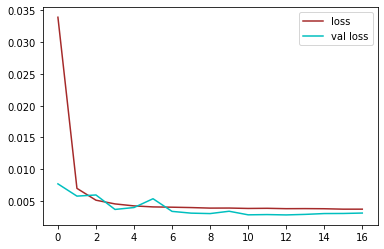

In [ ]:
plt.plot(gru_history.history['loss'], label='loss', color='brown')
plt.plot(gru_history.history['val_loss'], label='val loss',c='c')
plt.legend()
plt.show()

In [ ]:
# Perform predictions
predictions_future = model_gru.predict(X_test[-500:])

predictions_train = model_gru.predict(X_test[n_past:])

In [ ]:
prediction_future = np.repeat(predictions_future ,train_data.shape[1], axis=-1)
prediction_train = np.repeat(predictions_train ,train_data.shape[1], axis=-1)

In [ ]:
y_pred_future = scaler.inverse_transform(prediction_future)
y_pred_train = scaler.inverse_transform(prediction_train)

In [ ]:
y_pred_future.shape

(500, 4)

In [ ]:
y_pred_train.shape

(3512, 4)

In [ ]:
y_pred_future_temp=y_pred_future[:,:1]
y_pred_future_temp

array([[ 8.836718 ],
       [ 8.569737 ],
       [ 7.6124597],
       [ 6.914912 ],
       [ 7.361441 ],
       [ 7.5321198],
       [ 8.698688 ],
       [ 9.112114 ],
       [ 9.802045 ],
       [10.467508 ],
       [10.427866 ],
       [ 9.840803 ],
       [10.311434 ],
       [10.315422 ],
       [10.599321 ],
       [10.36082  ],
       [ 8.291537 ],
       [ 7.5664306],
       [ 7.7169695],
       [ 7.595023 ],
       [ 8.812732 ],
       [ 8.252878 ],
       [ 8.585303 ],
       [ 9.592354 ],
       [ 9.005455 ],
       [ 9.029968 ],
       [ 9.194049 ],
       [ 8.324213 ],
       [ 7.7276664],
       [ 8.230164 ],
       [ 8.03254  ],
       [ 7.9338975],
       [ 7.6959715],
       [ 7.8762574],
       [ 8.248616 ],
       [ 8.109278 ],
       [ 8.451314 ],
       [ 9.436201 ],
       [ 9.204676 ],
       [ 8.662539 ],
       [10.238571 ],
       [11.132243 ],
       [ 9.370732 ],
       [ 7.745529 ],
       [ 8.448543 ],
       [ 8.296558 ],
       [ 7.408984 ],
       [ 8.57

In [ ]:
y_pred_train_temp=y_pred_train[:,:1]
y_pred_train_temp

array([[ 6.3805275],
       [ 6.301772 ],
       [ 6.845955 ],
       ...,
       [10.017069 ],
       [ 9.988817 ],
       [10.862302 ]], dtype=float32)

In [ ]:
actual = np.repeat(y_test[n_past:] ,train_data.shape[1], axis=-1)
actual.shape
y_actual_train = scaler.inverse_transform(actual)
y_actual_train_temp = y_actual_train[:,:1]
y_actual_train_temp.shape

(3512, 1)

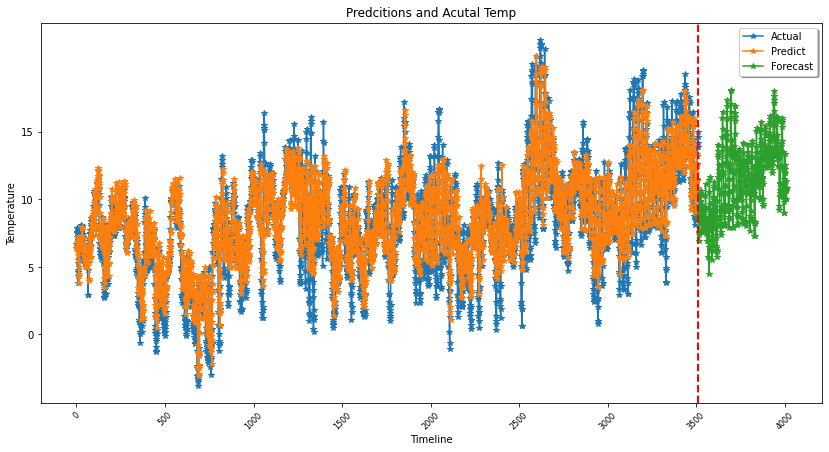

In [ ]:
lis = list(range(len(y_pred_train_temp)))
lis2 = list(range(len(y_pred_train_temp), len(y_pred_train_temp) + len(y_pred_future_temp)))

     
plt.figure(figsize=(14,7))
plt.plot(lis, y_actual_train_temp, label='Actual', marker="*")
plt.plot(lis, y_pred_train_temp, label='Predict', marker="*")
plt.plot(lis2, y_pred_future_temp, label='Forecast', marker="*")
plt.axvline(x = len(y_pred_train_temp), color='red', linewidth=2, linestyle='--')     
plt.yticks(np.arange(0, 20, 5))

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Temp', fontsize=12)
plt.xlabel('Timeline', fontsize=10)
plt.ylabel('Temperature', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()